In [22]:
from IPython.display import Image, clear_output
from IPython.core.display import HTML

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
%config InlineBackend.figure_format = 'svg' 
torch.manual_seed(2)   
np.random.seed(2)

In [25]:
import numpy as np
import pandas as pd
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

import random

from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

CUDA is available!  Training on GPU ...


In [26]:
d = pd.read_csv("train.csv")
d.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,0,0.165202,-0.478520,-2.257107,-0.553981,1.765257,1.299021,-0.046894,0.666681,0.680690,-1.671282,-0.153746,-0.195847,-0.220067,2.566026,-1.570657,2
1,1,-0.224334,-0.767142,-0.240347,-0.051352,0.305125,-1.721982,-2.465773,-1.101852,0.897459,-1.206320,0.729931,0.403281,-0.005451,-1.395800,-1.634428,0
2,2,0.089218,0.399756,0.947436,0.319036,0.688324,1.496136,0.191788,0.007435,0.163002,-1.375127,0.187362,-0.016887,0.766921,-1.150965,0.379291,4
3,3,-0.195872,0.507818,-1.799445,-1.169515,-0.923603,0.183832,-0.424816,0.592742,-0.075206,-0.845360,-0.927943,-0.328885,-0.701013,-0.630973,0.405728,1
4,4,-0.243670,0.079381,-0.780691,-2.072413,-1.380842,-0.140338,0.497398,-1.527575,-0.034950,-1.539090,-0.581833,0.441491,-0.140839,0.120535,0.105580,2


In [14]:
# Кол-во точек 
N_SAMPLES = 20

# Строим выборку для обучения 
x = torch.linspace(-1, 1, N_SAMPLES).view(N_SAMPLES, -1)
#y = x + 0.3 * torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))
y = torch.tensor([[-1.3122],[-0.6198],[-1.1807],[-1.0171],[-0.5700],[-0.4886],[-0.0489],[ 0.0027],[-0.4012],[ 0.1495]
                  ,[-0.2844],[ 0.1303],[ 0.3053],[ 0.7042],[ 0.5683],[ 1.1048],[ 0.4623],[ 0.4167],[ 0.8422],[ 1.2097]])

# Строим тестовую выборку
test_x = torch.linspace(-1, 1, N_SAMPLES).view(N_SAMPLES, -1)
#test_y = test_x + 0.3 * torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))
test_y = torch.tensor([[-1.3883],[-0.9020],[-0.8601],[-0.8968],[-0.2950],[-1.0038],[-0.5611],[ 0.4919],[-0.4285],[-0.0572],
                       [ 0.4683],[ 0.9315],[ 0.1591],[ 0.3946],[ 0.1438],[ 0.7278],[ 1.1072],[ 0.6730],[ 1.0141],[ 0.6687]])

Отобразим наши данные:

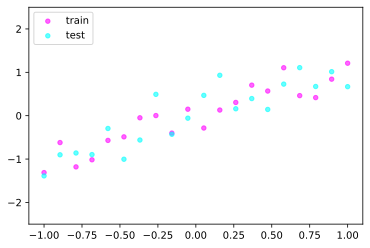

In [15]:
plt.scatter(x.numpy(), y.numpy(), c='magenta', s=20, alpha=0.6, label='train')
plt.scatter(test_x.numpy(), test_y.numpy(), c='cyan', s=20, alpha=0.6, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

 <b>Важно! На вход нам подается один нейрон, так как точка $x$ имеет один признак(координату), всего объектов 20. Для каждого объкта независимо от других прогнозируется его $y$, но линейное преобразование на определенном слое для каждого объекта одинакова, а веса этого слоя определяются из минимизации суммарной ошибки на $y$</b>
 
 Создадим нейронную сеть с 3 линейными слоями и в качестве нелинейности используем ReLU:

In [16]:
N_HIDDEN = 300
torch.manual_seed(2)   
np.random.seed(2)
net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)
print(net_overfitting)  # архитектура сети

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
)


<b>Порядок Dropout и ReLU не влияет на результат, так как неважно, выбрасывать нейрон после активации или до.

Добавим Dropout после первого и второго слоя с keep_rate=0.5, то есть удаляем нейрон с вероятностью 0.5:

In [17]:
torch.manual_seed(2)   
np.random.seed(2)
net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5), 
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5), 
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)
print(net_dropped) # архитектура сети

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=300, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=1, bias=True)
)


Зададим градиентный спуск каждой нейронной сети:

In [18]:
optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(net_dropped.parameters(), lr=0.01)

Зададим квадратичную функцию потерь:

In [19]:
loss_func = torch.nn.MSELoss()

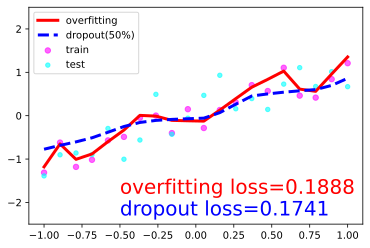

overfitting loss train dropout loss train
1.4693			1.4554
0.0818			0.1057
0.0654			0.0694
0.0582			0.0705
0.0543			0.0895
0.0507			0.0633
0.0468			0.0726
0.0424			0.0710
0.0380			0.0810
0.0345			0.0867
0.0322			0.0816
0.0306			0.0599
0.0294			0.0699
0.0277			0.0837
0.0276			0.0650
0.0254			0.0581
0.0269			0.0669
0.0230			0.0559
0.0217			0.0630
0.0224			0.0646
0.0202			0.0784
0.0184			0.0631
0.0172			0.0575
0.0178			0.0686
0.0223			0.0889

overfitting loss    dropout loss
1.4536			1.4576
0.1330			0.1505
0.1129			0.1134
0.1185			0.1170
0.1227			0.1430
0.1278			0.1172
0.1336			0.1313
0.1398			0.1320
0.1490			0.1411
0.1594			0.1537
0.1686			0.1461
0.1723			0.1282
0.1759			0.1328
0.1772			0.1562
0.1811			0.1276
0.1809			0.1317
0.1861			0.1321
0.1814			0.1250
0.1811			0.1431
0.1847			0.1388
0.1817			0.1585
0.1799			0.1438
0.1798			0.1302
0.1843			0.1493
0.1888			0.1741


In [20]:
# Ошибки на y и test_y
error = []
error_test = []
for t in range(500):
    # Пропустим x по нейронной сети
    pred_ofit = net_overfitting(x)
    pred_drop = net_dropped(x)
    
    loss_ofit = loss_func(pred_ofit, y)
    loss_drop = loss_func(pred_drop, y)

    # Cделаем шаг градиентного спуска
    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    loss_ofit.backward()
    loss_drop.backward()
    optimizer_ofit.step()
    optimizer_drop.step()
    
    if t % 20 == 0:
        # перейдем к режиму eval, чтобы учесть поправку dropout
        net_overfitting.eval()
        net_dropped.eval()

        # plotting
        clear_output(wait=True)
        sleep(0.05)
        
         # Пропустим test_x по нейронной сети
        test_pred_ofit = net_overfitting(test_x)
        test_pred_drop = net_dropped(test_x)
        
        #Отобразим наши данные и предсказания различных нейронных сетей на тестовых данных:
        plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=30, alpha=0.6, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=20, alpha=0.6, label='test')
        plt.plot(test_x.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(test_x.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        
        # Ошибка на y и на на test_y
        error.append((loss_func(test_pred_ofit, y).data.numpy(), loss_func(test_pred_drop, y).data.numpy()))
        error_test.append((loss_func(test_pred_ofit, test_y).data.numpy(), loss_func(test_pred_drop, test_y).data.numpy()))
        
        plt.text(-0.5, -1.8, 'overfitting loss=%.4f' % loss_func(test_pred_ofit, test_y).data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.text(-0.5, -2.3, 'dropout loss=%.4f' % loss_func(test_pred_drop, test_y).data.numpy(), fontdict={'size': 20, 'color': 'blue'})
        plt.legend(loc='upper left'); plt.ylim((-2.5, 2.5))
        plt.show()
        
        # вернемся к режиму train
        net_overfitting.train()
        net_dropped.train()

# Выведим ошибки двух сетей попарно на y:
print('overfitting loss train', 'dropout loss train')
for i in range(len(error)):
    print('%.4f\t\t\t%.4f' % (error[i][0], error[i][1]))

print()
# Выведим ошибки двух сетей попарно на test_y:
print('overfitting loss', '   dropout loss')
for i in range(len(error)):
    print('%.4f\t\t\t%.4f' % (error_test[i][0], error_test[i][1]))

# Вопросы:
1. Какая суммарная квадратичная ошибка между $y$ и $test\_y$? (c помощью loss_func)
<br>Ответ: 0.1770
2. Сколько параметров у линейного скрытого слоя (не забудьте про свободный член b)?
<br> Ответ: 90300
3. Какая у вас получилась ошибка $overfitting\:loss\:train$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.02
4. Какая у вас получилась ошибка $dropout\:loss\:train$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.07
5. Какая у вас получилась ошибка $overfitting\:loss$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.19
6. Какая у вас получилась ошибка $dropout\:loss$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.15

<br> Сравните 3, 4 и подумайте, почему так получилось?
<br> Сравните 4, 5 и подумайте, почему так получилось?
<br> Так же сравните 4, 5 с предыдущими двумя ошибками.